In [1]:
import os
import json
import cv2
import mediapipe as mp
import numpy as np
from PIL import Image
from IPython.display import display

from tqdm.auto import tqdm

2024-01-23 22:52:29.554403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ant/miniconda3/envs/psl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
# init(autoreset=True)
def get_first_and_last(video_path):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()

    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    first, last = None, None

    current_frame = 0
    diffs = []
    last_img = None
    first_img, last_img = None, None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the BGR image to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if last_img is None:
            last_img = rgb_frame
        else:
            diffs.append(np.sum(np.abs(last_img - rgb_frame)))

        # Process the frame and get landmarks
        results = hands.process(rgb_frame)
        # print(results.multi_hand_landmarks is None, current_frame)
        if not first and results.multi_hand_landmarks:
            first = current_frame
            first_img = rgb_frame
            last = first
            last_img = rgb_frame
            # print('if', current_frame)
        elif first and results.multi_hand_landmarks:
            # print('here', current_frame)
            last = max(last, current_frame)
            last_img = rgb_frame
        current_frame += 1
    return first, last, diffs, first_img, last_img


def value_imputation(x, mask):
    x = x.copy()
    l = -1
    for i, m in enumerate(mask):
        if m:
            l = i
        if not m:
            for r in range(i, len(mask)):
                if mask[r]:
                    break
            else:
                r = -1
            if l > -1 and r > -1:
                x[i] = (x[l] + x[r]) / 2
            elif l > -1 and r < 0:
                x[i] = x[l]
            elif l < 0 and r > -1:
                x[i] = x[r]
            else:
                raise ValueError('No landmarks found')
    return x

def video_with_landmarks(video_path):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()
    first, last, _, _, _ = get_first_and_last(video_path)
    # print(first, last)
    cap = cv2.VideoCapture(video_path)
    # frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = last - first
    # print(frame_count)
    k = 5
    frames = np.linspace(first, last, k+2).astype(int)[1:-1]
    # q25, q50, q75 = frame_count // 4, frame_count // 2, 3 * frame_count // 4
    # frames = [q25, q50, q75]
    # frames = [f + first for f in frames]
    # print(frames)
    current = 0
    landmarks_data = []
    mask = [True]*k
    while cap.isOpened():
        # Set the position to the current frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frames[current])
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the BGR image to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_frame)
        plt.show()

        # Process the frame and get landmarks
        results = hands.process(rgb_frame)
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0].landmark
            landmarks_data.append([[landmark.x, landmark.y, landmark.z] for landmark in hand_landmarks])
        current += 1
        if current + 1 > len(frames):
            break
    
    cap.release()
    landmarks_data = np.array(landmarks_data)
    # print(landmarks_data.shape)
    return landmarks_data



I0000 00:00:1706051790.383905   69259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1706051790.394609   69822 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.146.02), renderer: NVIDIA GeForce GTX 970/PCIe/SSE2
I0000 00:00:1706051790.401079   69259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1706051790.407993   69831 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.146.02), renderer: NVIDIA GeForce GTX 970/PCIe/SSE2


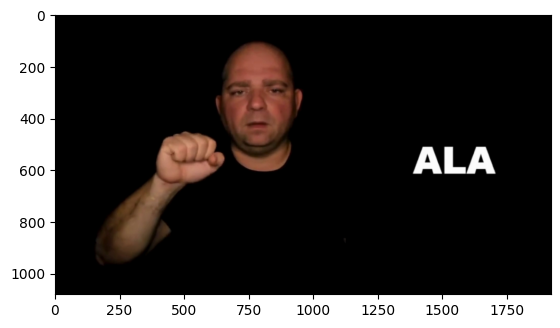

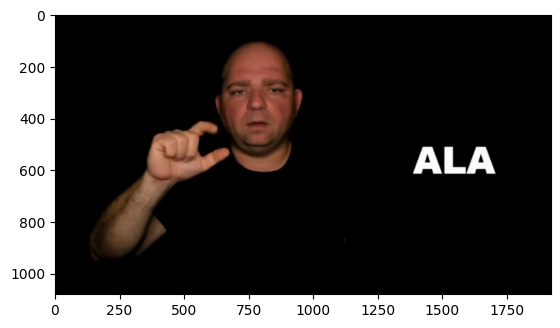

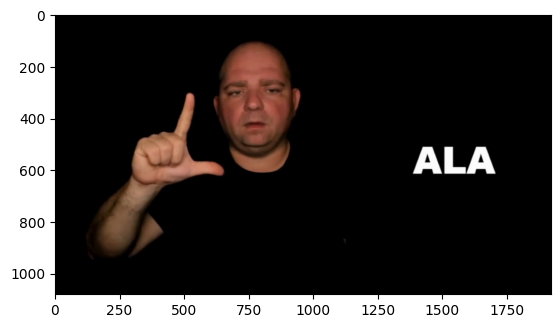

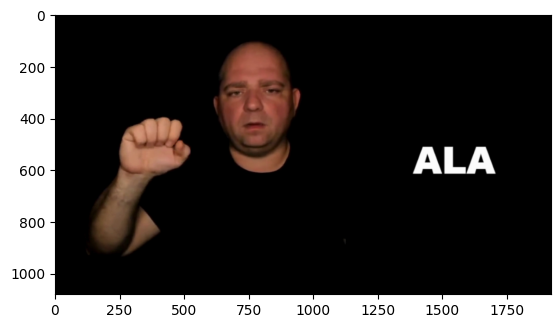

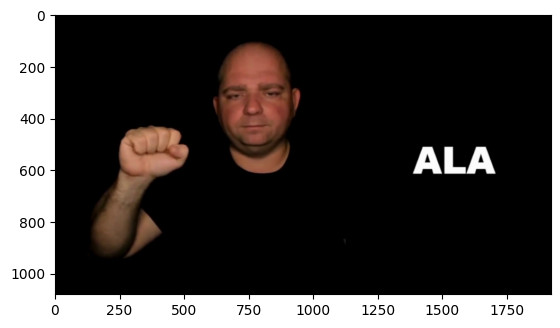

In [50]:
data = video_with_landmarks('/home/ant/projects/psl/dataset/Videos/words/ALA.mp4')

In [43]:
first, last, diffs, f_img, l_img = get_first_and_last('/home/ant/projects/psl/dataset/Videos/words/AL.mp4')

I0000 00:00:1706051500.060644   69259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1706051500.071011   69725 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.146.02), renderer: NVIDIA GeForce GTX 970/PCIe/SSE2


In [44]:
first, last

(28, 118)

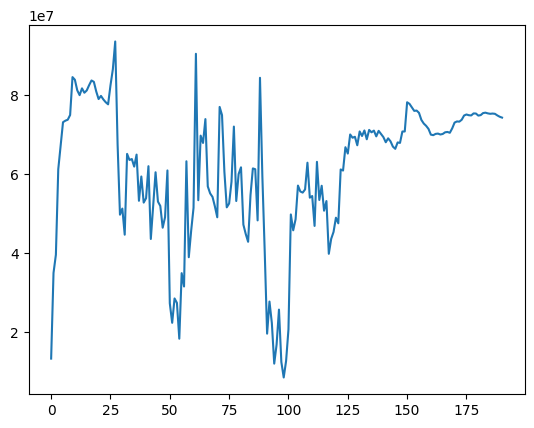

In [45]:
import matplotlib.pyplot as plt
plt.plot(diffs)
plt.show()

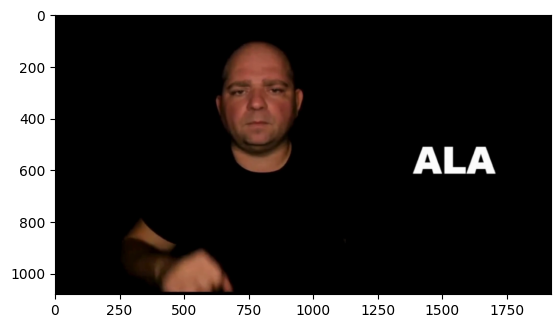

In [41]:
plt.imshow(f_img)

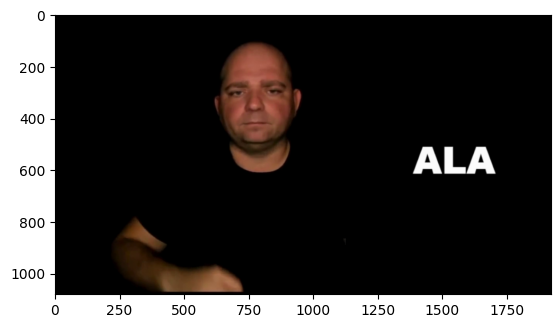

In [42]:
plt.imshow(l_img)

In [99]:
# Function to extract hand landmarks from a video
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
def landmarks_timeseries(video_path):
    # Open the video file for reading
    cap = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Set the frame rate for extracting landmarks
    frame_rate = 0.2

    # Calculate the number of frames to skip based on the frame rate
    frames_to_skip = int(fps * frame_rate)

    landmarks_data = []
    current_frame = 0

    # Loop through the frames of the video
    while cap.isOpened():
        # Set the position to the current frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

        # Read the current frame from the video
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame and get hand landmarks using Mediapipe
        results = hands.process(rgb_frame)
        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0].landmark
            

            # Append the 3D coordinates of hand landmarks to the list
            landmarks_data.append([[landmark.x, landmark.y, landmark.z] for landmark in hand_landmarks])
            x = np.array(landmarks_data[-1]).flatten().reshape(1, -1)
            print(x[0, :6])
            print(x.shape)
            label = clf.predict(x)
            prob = clf.predict_proba(x).max(-1)
            for landmark in landmarks_data[-1]:
                x, y = int(landmark[0] * rgb_frame.shape[1]), int(landmark[1] * rgb_frame.shape[0])
                cv2.circle(rgb_frame, (x, y), 5, (0, 255, 0), -1)
            plt.imshow(rgb_frame)
            plt.title(f'{label} {prob}')
            plt.show()
        # Move to the next frame based on the frames to skip
        current_frame += frames_to_skip

    # Release the video capture object
    cap.release()
    del cap

    # Reshape the landmarks data into a 2D array
    landmarks_data = np.array(landmarks_data).reshape(len(landmarks_data), -1)

    return landmarks_data

I0000 00:00:1706053661.304874   69259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1706053661.317919   71304 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.146.02), renderer: NVIDIA GeForce GTX 970/PCIe/SSE2


In [102]:
from joblib import dump, load
clf = load('LogisticRegression.joblib') 
# clf = load('RandomForestClassifier.joblib') 

[ 2.50266850e-01  9.06631708e-01  1.28835879e-07  2.79181004e-01
  8.68636250e-01 -2.07104553e-02]
(1, 63)


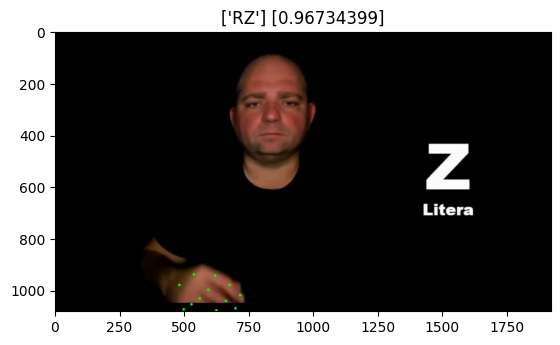

[ 2.44811878e-01  6.71232283e-01  1.40841493e-07  2.73162752e-01
  6.53261483e-01 -4.44225362e-03]
(1, 63)


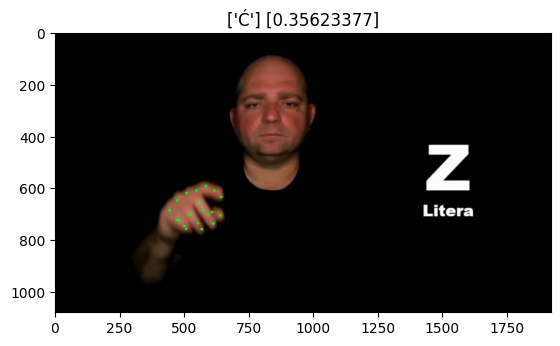

[ 2.57465154e-01  5.93722522e-01  1.30742720e-07  2.82892346e-01
  5.83085001e-01 -1.22385798e-02]
(1, 63)


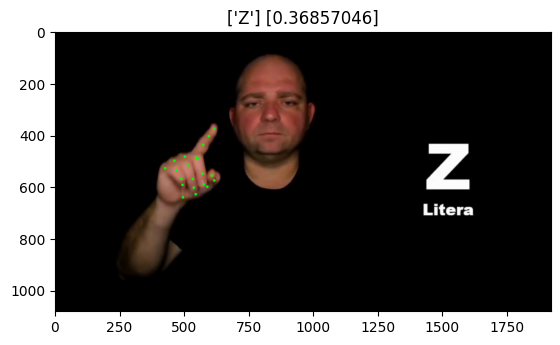

[ 2.64312804e-01  5.59848309e-01  1.71064798e-07  2.97246218e-01
  5.39722681e-01 -1.24461818e-02]
(1, 63)


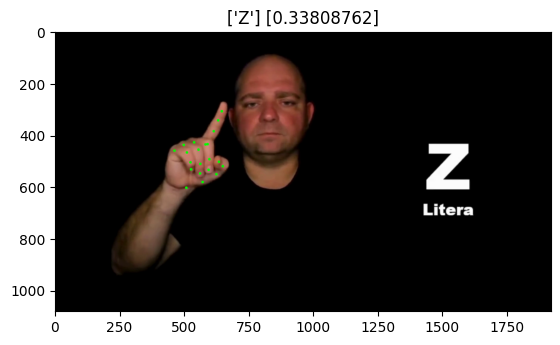

[ 2.69862443e-01  5.54110646e-01  1.10604184e-07  3.00820380e-01
  5.40665448e-01 -1.41858123e-02]
(1, 63)


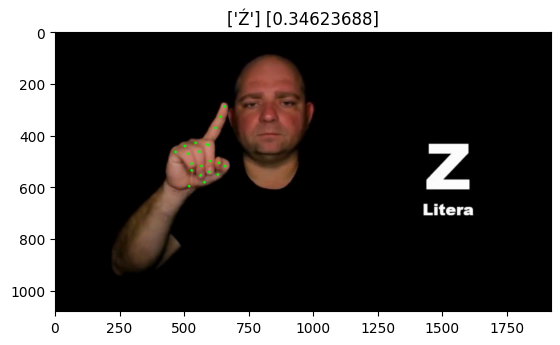

[ 2.38522977e-01  5.61064780e-01  8.41817069e-08  2.69787133e-01
  5.38652122e-01 -1.26397023e-02]
(1, 63)


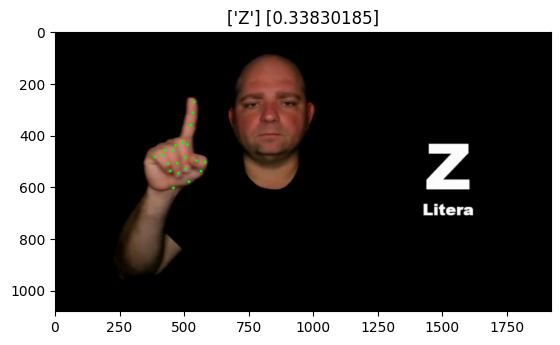

[ 2.16862142e-01  5.79760969e-01  4.83747833e-08  2.45882750e-01
  5.53633571e-01 -1.61962360e-02]
(1, 63)


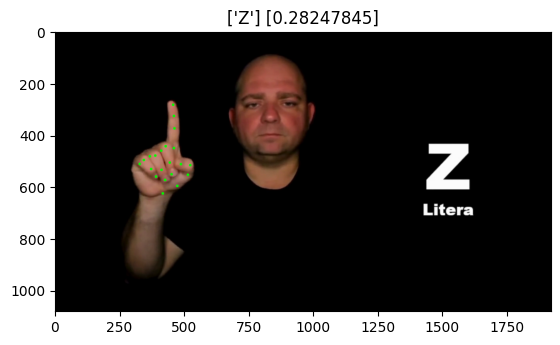

[ 2.48836070e-01  6.34799540e-01 -6.52719976e-08  2.75920898e-01
  6.11528039e-01 -1.52969714e-02]
(1, 63)


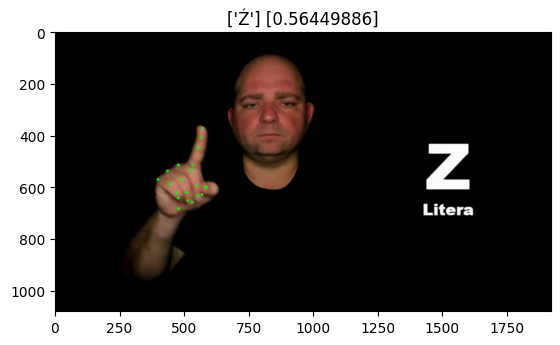

[ 2.63904631e-01  6.83999956e-01 -5.80023247e-08  2.94463307e-01
  6.62404418e-01 -1.23528736e-02]
(1, 63)


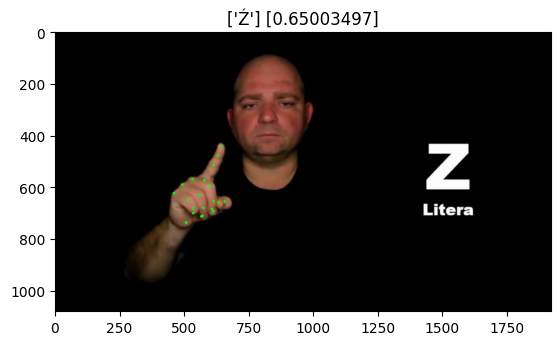

[ 2.42890552e-01  6.99918091e-01  5.58597151e-08  2.70489991e-01
  6.73650265e-01 -1.19310943e-02]
(1, 63)


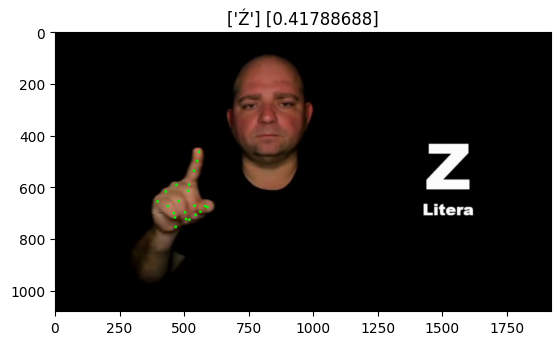

[ 2.07419366e-01  6.93592072e-01 -5.14319787e-09  2.30310515e-01
  6.75589502e-01 -1.92439463e-02]
(1, 63)


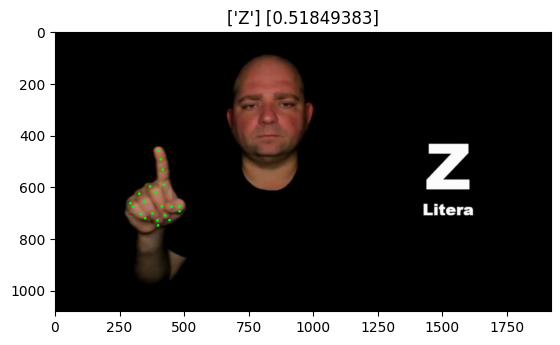

[ 2.02902198e-01  7.05542922e-01  5.71943666e-08  2.26059303e-01
  6.82910323e-01 -1.77961197e-02]
(1, 63)


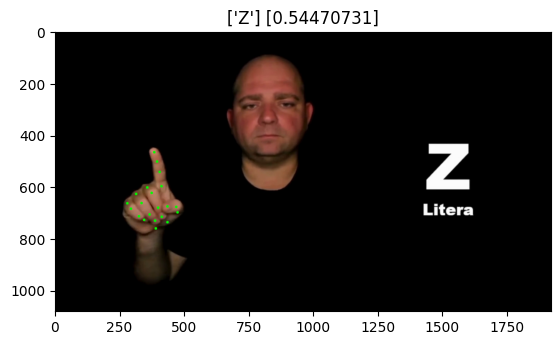

[ 2.03829437e-01  7.05741763e-01  3.36827917e-08  2.28128701e-01
  6.82140172e-01 -1.63509566e-02]
(1, 63)


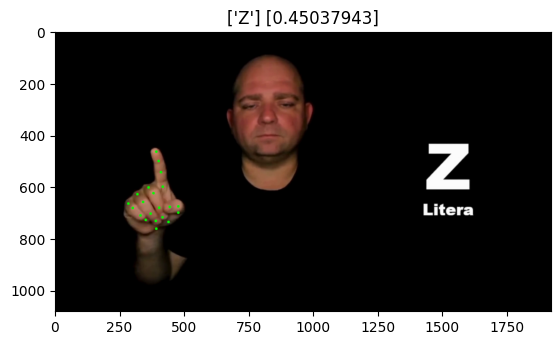

[ 2.08224356e-01  7.09164143e-01  2.90228606e-08  2.32511878e-01
  6.86778963e-01 -1.73656531e-02]
(1, 63)


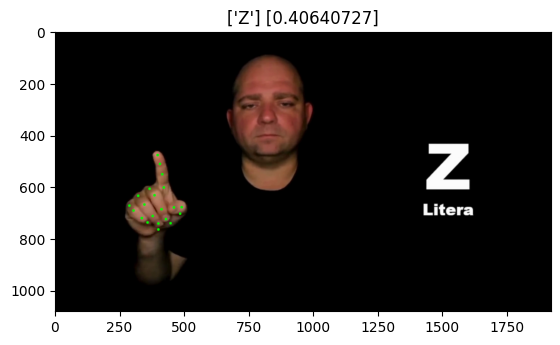

[ 2.21853152e-01  7.23538697e-01 -1.46972576e-08  2.41827562e-01
  7.00924814e-01 -1.53024020e-02]
(1, 63)


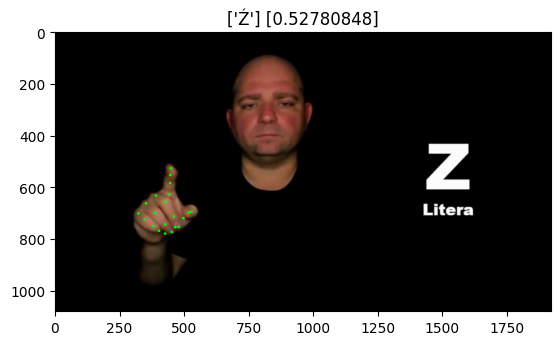

[ 2.73873597e-01  8.03508162e-01  1.66503071e-07  2.97066510e-01
  7.80654430e-01 -5.56603959e-03]
(1, 63)


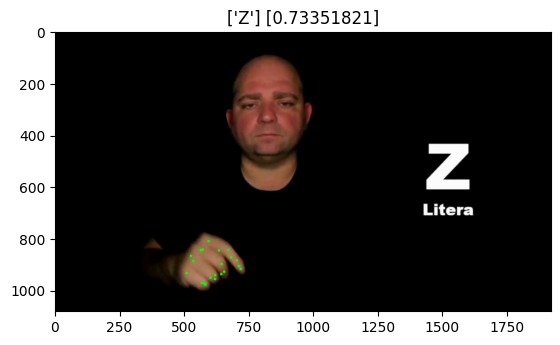

In [105]:
data = landmarks_timeseries('/home/ant/projects/psl/dataset/Videos/alphabet/Z.mp4')

[ 2.48507529e-01  8.35776269e-01 -6.39981437e-08  2.81406820e-01
  8.24103951e-01 -4.85495757e-03]
(1, 63)


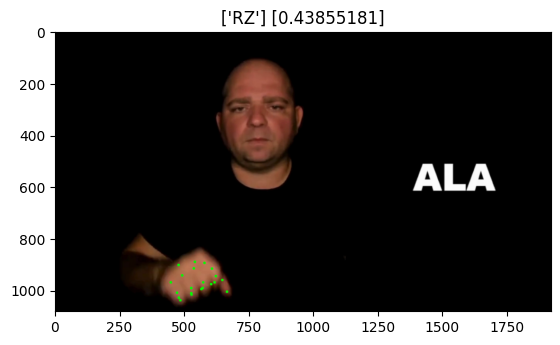

[ 2.43486404e-01  6.82966411e-01 -1.53838599e-07  2.71011204e-01
  6.70828581e-01 -1.14979092e-02]
(1, 63)


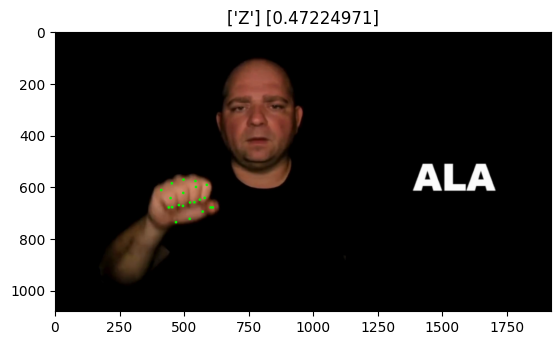

[ 2.43513077e-01  6.00443482e-01 -1.80224049e-07  2.78077692e-01
  5.81783652e-01 -7.89736584e-03]
(1, 63)


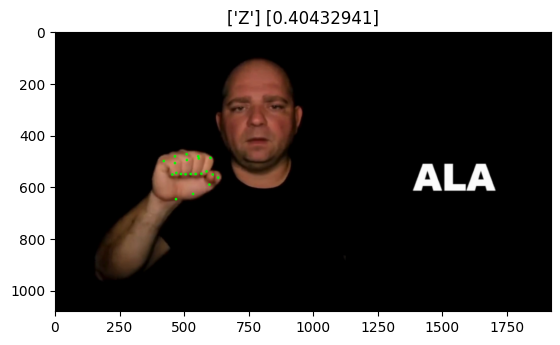

[ 2.46977419e-01  6.01239920e-01 -1.14013837e-07  2.84663707e-01
  5.77654481e-01 -7.34299282e-03]
(1, 63)


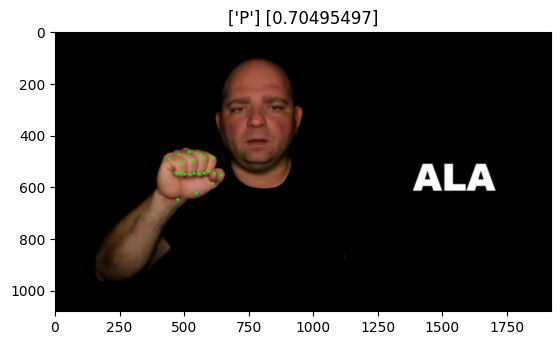

[ 2.45192975e-01  6.09044433e-01 -1.91925423e-07  2.81297475e-01
  5.88625729e-01 -1.04632247e-02]
(1, 63)


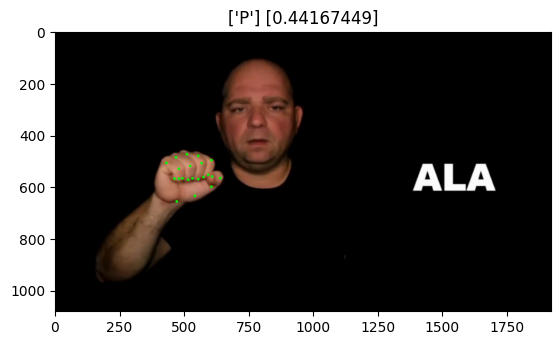

[ 2.42570952e-01  6.05024934e-01 -1.77867577e-07  2.80027360e-01
  5.82828820e-01 -9.37375147e-03]
(1, 63)


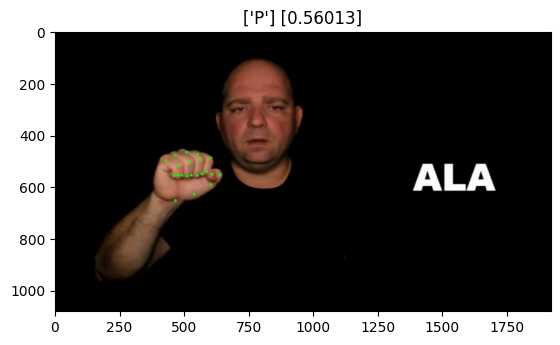

[ 2.39598125e-01  5.86098194e-01 -7.48108064e-08  2.72052974e-01
  5.71488440e-01 -1.03502823e-02]
(1, 63)


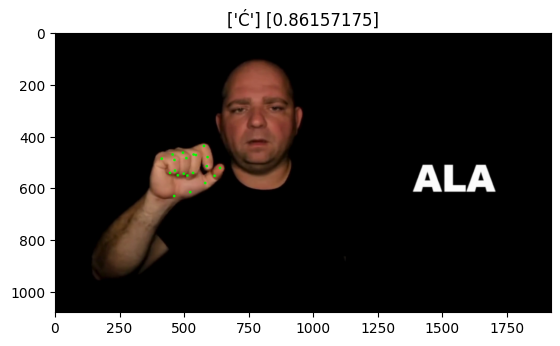

[ 2.25644469e-01  5.83686948e-01  8.98997570e-08  2.56778389e-01
  5.74901581e-01 -9.83880367e-03]
(1, 63)


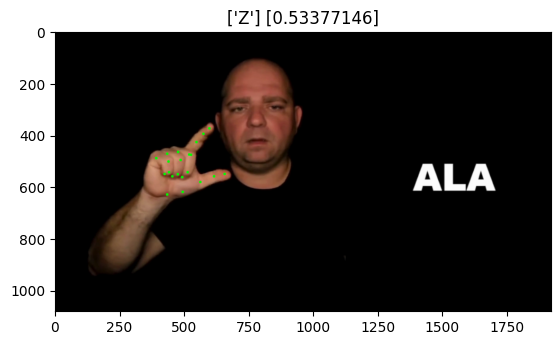

[ 2.15060711e-01  5.91569424e-01  9.80766615e-08  2.47564837e-01
  5.81231236e-01 -1.20279398e-02]
(1, 63)


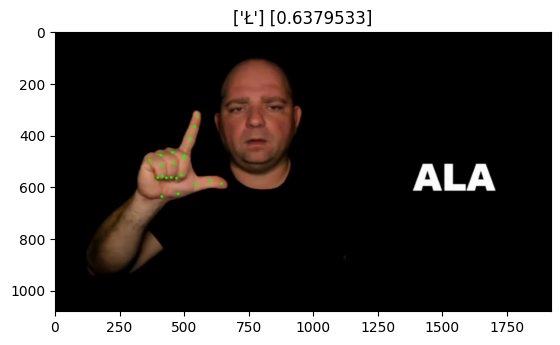

[ 2.04795748e-01  6.04553461e-01  6.58147457e-08  2.38834262e-01
  5.90580106e-01 -1.20394547e-02]
(1, 63)


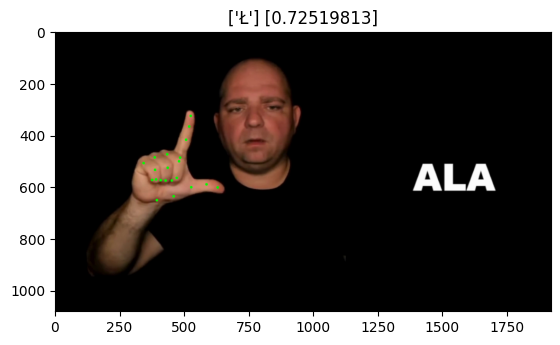

[ 2.01397806e-01  5.99811077e-01  8.16030550e-08  2.38662779e-01
  5.87891757e-01 -1.34452553e-02]
(1, 63)


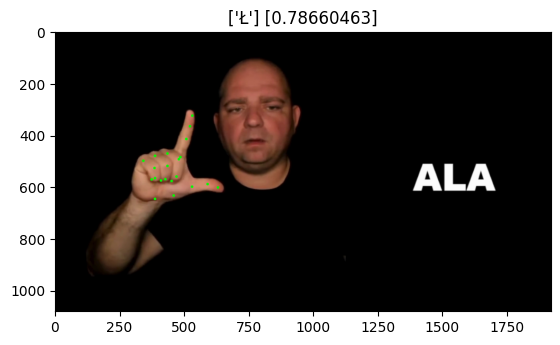

[ 1.96120024e-01  5.88310719e-01  7.74228539e-08  2.32462347e-01
  5.74730754e-01 -1.20196939e-02]
(1, 63)


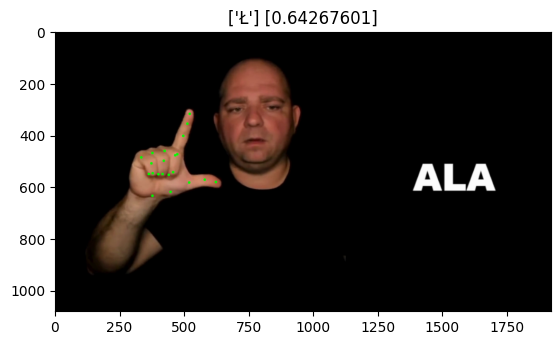

[ 1.82311967e-01  5.69645226e-01 -1.07746256e-08  2.19524205e-01
  5.59637904e-01 -1.10543445e-02]
(1, 63)


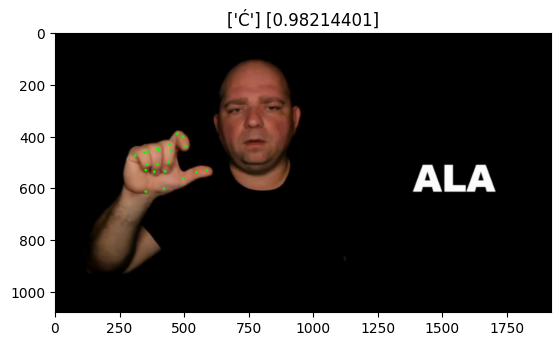

[ 1.74501449e-01  5.71342885e-01 -1.87863606e-07  2.11861432e-01
  5.56743026e-01 -1.04977768e-02]
(1, 63)


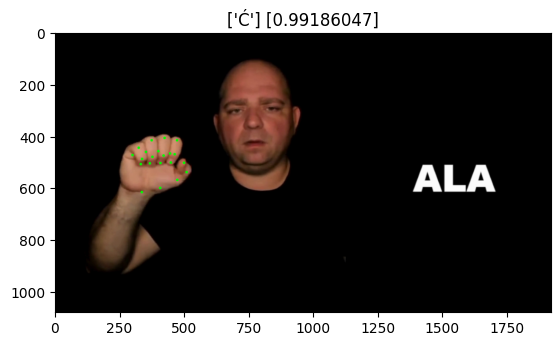

[ 1.72989905e-01  5.74379921e-01 -1.95389745e-07  2.09422976e-01
  5.57461679e-01 -1.02987951e-02]
(1, 63)


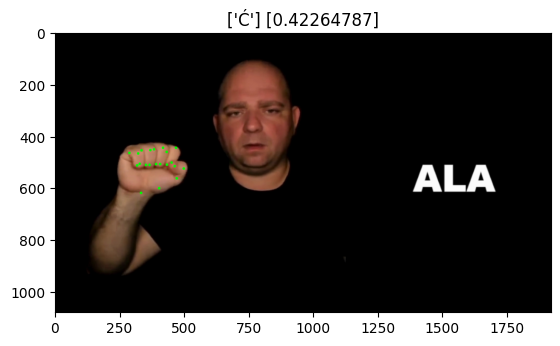

[ 1.73858911e-01  5.77348828e-01 -1.77217757e-07  2.09238023e-01
  5.58900356e-01 -1.25821503e-02]
(1, 63)


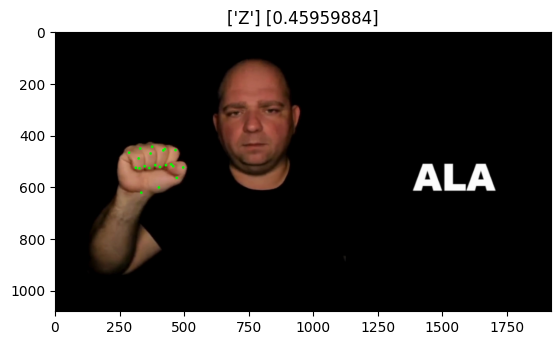

[ 1.76522285e-01  5.77260494e-01 -1.66245258e-07  2.11944431e-01
  5.58584690e-01 -1.15044434e-02]
(1, 63)


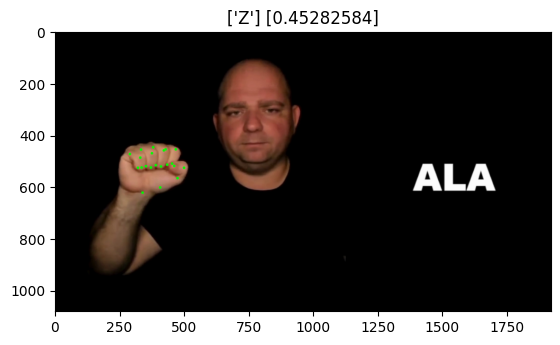

[ 1.78692698e-01  5.82106054e-01 -1.78337075e-07  2.15208739e-01
  5.62072098e-01 -1.19628683e-02]
(1, 63)


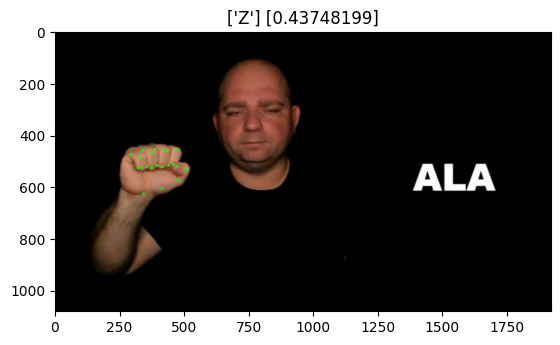

[ 2.00488776e-01  6.34554327e-01 -1.69253269e-07  2.30515048e-01
  6.20385766e-01 -1.21832853e-02]
(1, 63)


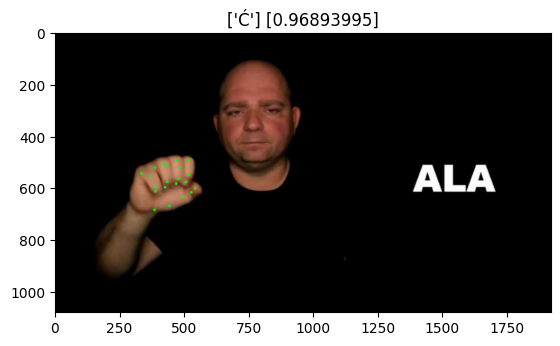

[ 2.64573723e-01  6.84690654e-01  9.58927373e-08  2.76808113e-01
  6.83442235e-01 -8.91377218e-03]
(1, 63)


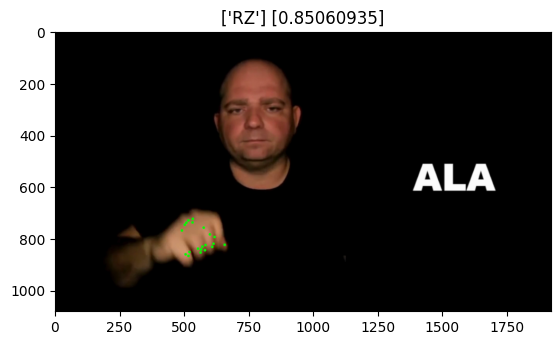

In [103]:
data = landmarks_timeseries('/home/ant/projects/psl/dataset/Videos/words/ALA.mp4')